# Bounding Box Models for Image Recognition

To improve the signal-to-noise ratio of images

## Initial Setup

Auto update from code base

In [1]:
%load_ext autoreload
%autoreload 2

Import libraries

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm
import PIL
from PIL.ImageDraw import Draw
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms

from src.data import pil_loader, BoundingBoxDataset
from src.image_preprocessing import draw_dots
from src.model_api_pytorch import BoundingBoxCNN, train_bb_model

Read in bounding box coordinates

In [3]:
bb_beauty_train = pd.read_csv('data/derived/beauty_bb_train.csv')
bb_beauty_val = pd.read_csv('data/derived/beauty_bb_val.csv')

bb_fashion_train = pd.read_csv('data/derived/fashion_bb_train.csv')
bb_fashion_val = pd.read_csv('data/derived/fashion_bb_val.csv')

bb_mobile_train = pd.read_csv('data/derived/mobile_bb_train.csv')
bb_mobile_val = pd.read_csv('data/derived/mobile_bb_val.csv')

## Compute Rescale Factors for Images

Determine original height and width of images, and rescale factor for height and width

__Note__:
$$Width factor = \frac{resize width}{original width}$$
$$Height factor = \frac{resize height}{original height}$$

In [4]:
resize_width, resize_height = 224, 224

for dataframe in [bb_beauty_train, bb_beauty_val, bb_fashion_train, bb_fashion_val, bb_mobile_train, bb_mobile_val]:
    num_images = len(dataframe)
    pbar = tqdm(total=num_images)
    width_list, height_list = list(), list()
    width_factor_list, height_factor_list = list(), list()
    for image_path in dataframe['image_path']:
        image_path_extended = os.path.join('data/raw', image_path)
        image = pil_loader(image_path_extended)
        width, height = image.size
        width_factor, height_factor = resize_width / width, resize_height / height
        width_list.append(width)
        height_list.append(height)
        width_factor_list.append(width_factor)
        height_factor_list.append(height_factor)
        pbar.update()
    dataframe['width'] = width_list
    dataframe['height'] = height_list
    dataframe['width_factor'] = width_factor_list
    dataframe['height_factor'] = height_factor_list
    pbar.close()

100%|██████████| 20/20 [00:00<00:00, 65.74it/s]


## Prepare data for Model Training

Filter out "easy" data

In [5]:
bb_beauty_train_easy = bb_beauty_train[bb_beauty_train['difficulty'] == 'easy']
bb_fashion_train_easy = bb_fashion_train[bb_fashion_train['difficulty'] == 'easy']
bb_mobile_train_easy = bb_mobile_train[bb_mobile_train['difficulty'] == 'easy']

In [6]:
bb_beauty_train_easy.shape, bb_fashion_train_easy.shape, bb_mobile_train_easy.shape

((43, 10), (42, 10), (33, 10))

Transforms for images

In [7]:
transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Create datasets for training

In [8]:
dataset_beauty_train = BoundingBoxDataset(df=bb_beauty_train, root_dir='data/raw', transform=True, horizontal_flip=True)
dataset_beauty_val = BoundingBoxDataset(df=bb_beauty_val, root_dir='data/raw', transform=True, horizontal_flip=False)

dataset_fashion_train = BoundingBoxDataset(df=bb_fashion_train, root_dir='data/raw', transform=True, horizontal_flip=True)
dataset_fashion_val = BoundingBoxDataset(df=bb_fashion_val, root_dir='data/raw', transform=True, horizontal_flip=False)

dataset_mobile_train = BoundingBoxDataset(df=bb_mobile_train, root_dir='data/raw', transform=True, horizontal_flip=True)
dataset_mobile_val = BoundingBoxDataset(df=bb_mobile_val, root_dir='data/raw', transform=True, horizontal_flip=False)

## Build models

Transfer learning with ResNet18

In [9]:
## Beauty
model_beauty_ft = models.resnet18(pretrained=True)
# Freeze pre-trained layers
# for param in model_beauty_ft.parameters():
#     param.requires_grad = False
# Unfreeze last layer
for name, child in model_beauty_ft.named_children():
    if name in ['layer4']:
        print(name, 'is unfrozen')
        for param in child.parameters():
            param.requires_grad = True
    else:
        print(name, 'is frozen')
        for param in child.parameters():
            param.requires_grad = False
# model_beauty_bb = BoundingBoxCNN(model_pretrained=model_beauty_ft, dropout_rate=0.3)

## Fashion
model_fashion_ft = models.resnet18(pretrained=True)
# Freeze pre-trained layers
for param in model_fashion_ft.parameters():
    param.requires_grad = False
# model_fashion_bb = BoundingBoxCNN(model_pretrained=model_fashion_ft, dropout_rate=0.3)

## Mobile
model_mobile_ft = models.resnet18(pretrained=True)
# Freeze pre-trained layers
for param in model_mobile_ft.parameters():
    param.requires_grad = False
# model_mobile_bb = BoundingBoxCNN(model_pretrained=model_mobile_ft, dropout_rate=0.3)

conv1 is frozen
bn1 is frozen
relu is frozen
maxpool is frozen
layer1 is frozen
layer2 is frozen
layer3 is frozen
layer4 is unfrozen
avgpool is frozen
fc is frozen


Build additional FC layer after pre-trained models

In [10]:
# Number of features in output of pretrained model
num_ftrs_beauty = model_beauty_ft.fc.out_features
fc_size_beauty = int(round(num_ftrs_beauty / 2, -2))
num_ftrs_fashion = model_fashion_ft.fc.out_features
fc_size_fashion = int(round(num_ftrs_fashion / 3, -2))
num_ftrs_mobile = model_mobile_ft.fc.out_features
fc_size_mobile = int(round(num_ftrs_mobile / 3, -2))

model_beauty_bb = nn.Sequential(model_beauty_ft,
                                nn.Linear(num_ftrs_beauty, fc_size_beauty),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(fc_size_beauty, fc_size_beauty),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(fc_size_beauty, fc_size_beauty),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(fc_size_beauty, 4))

model_fashion_bb = nn.Sequential(model_fashion_ft,
                                 nn.Linear(num_ftrs_fashion, fc_size_fashion),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.3),
                                 nn.ReLU(),
                                 nn.Linear(fc_size_fashion, 4))

model_mobile_bb = nn.Sequential(model_mobile_ft,
                                nn.Linear(num_ftrs_mobile, fc_size_mobile),
                                nn.ReLU(),
                                nn.Dropout(p=0.3),
                                nn.ReLU(),
                                nn.Linear(fc_size_mobile, 4))

Define device (CPU or CUDA), configure models for multiple GPUs and copy models to device

In [11]:
# device0 = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# print(device0)
# if torch.cuda.device_count() == 2:
#     device1 = torch.device('cuda:1')
#     print(device1)

# model_beauty_bb.set_multiple_gpus()
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        model_beauty_bb = nn.DataParallel(model_beauty_bb)
        model_fashion_bb = nn.DataParallel(model_fashion_bb)
        model_mobile_bb = nn.DataParallel(model_mobile_bb)
    
    model_beauty_bb.cuda()
    model_fashion_bb.cuda()
    model_mobile_bb.cuda()

## Train Models

### Beauty

Define criterion and optimizer

In [12]:
criterion = nn.MSELoss()
optimizer_beauty = optim.Adam(filter(lambda p: p.requires_grad, model_beauty_bb.parameters()), lr=1e-4, weight_decay=0.01)

Training with easy data only

In [13]:
num_epochs = 10

model_beauty_bb, train_loss_beauty_1, val_loss_beauty_1 = train_bb_model(model=model_beauty_bb,
                                                                         df_train=bb_beauty_train_easy,
                                                                         df_val=bb_beauty_val,
                                                                         root_dir='data/raw',
                                                                         criterion=criterion,
                                                                         optimizer=optimizer_beauty,
                                                                         bootstrap_size=180,
                                                                         num_epochs=num_epochs,
                                                                         batch_size=4,
                                                                         num_workers=0)

  0%|          | 0/45 [00:00<?, ?it/s]

Epoch 1/10
----------


  2%|▏         | 1/45 [00:00<00:05,  8.03it/s]

Training Loss: 690349.7188
Vallidation Loss: 78965.8422

Epoch 2/10
----------


  2%|▏         | 1/45 [00:00<00:05,  8.43it/s]

Training Loss: 514972.9594
Vallidation Loss: 167900.7437

Epoch 3/10
----------


  2%|▏         | 1/45 [00:00<00:05,  8.61it/s]

Training Loss: 321600.9163
Vallidation Loss: 278493.6586

Epoch 4/10
----------


  2%|▏         | 1/45 [00:00<00:05,  7.45it/s]

Training Loss: 329016.4455
Vallidation Loss: 505399.5547

Epoch 5/10
----------


  2%|▏         | 1/45 [00:00<00:06,  6.69it/s]

Training Loss: 250724.3507
Vallidation Loss: 304935.2211

Epoch 6/10
----------


  2%|▏         | 1/45 [00:00<00:05,  7.89it/s]

Training Loss: 352967.2840
Vallidation Loss: 387390.9406

Epoch 7/10
----------


  2%|▏         | 1/45 [00:00<00:05,  7.37it/s]

Training Loss: 286527.9531
Vallidation Loss: 216488.3484

Epoch 8/10
----------


  2%|▏         | 1/45 [00:00<00:06,  6.71it/s]

Training Loss: 286320.9642
Vallidation Loss: 310118.5563

Epoch 9/10
----------


  2%|▏         | 1/45 [00:00<00:07,  6.11it/s]

Training Loss: 199603.4097
Vallidation Loss: 480037.1750

Epoch 10/10
----------


100%|██████████| 5/5 [00:00<00:00, 10.02it/s]

Training Loss: 270359.9476
Vallidation Loss: 924366.7438

Training completed in 1m 8s


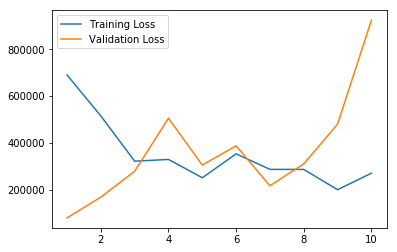

In [14]:
plt.plot(range(1, num_epochs+1), train_loss_beauty_1, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_beauty_1, label='Validation Loss')
plt.legend(loc='best')
# plt.savefig('bb_loss_beauty.png')

Training with full dataset

In [15]:
optimizer_beauty = optim.Adam(filter(lambda p: p.requires_grad, model_beauty_bb.parameters()), lr=1e-4, weight_decay=0.05)

num_epochs = 50

model_beauty_bb, train_loss_beauty_2, val_loss_beauty_2 = train_bb_model(model=model_beauty_bb,
                                                                         df_train=bb_beauty_train,
                                                                         df_val=bb_beauty_val,
                                                                         root_dir='data/raw',
                                                                         criterion=criterion,
                                                                         optimizer=optimizer_beauty,
                                                                         bootstrap_size=180,
                                                                         num_epochs=num_epochs,
                                                                         batch_size=4,
                                                                         num_workers=0)

  2%|▏         | 1/45 [00:00<00:06,  6.68it/s]

Epoch 1/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.83it/s]

Training Loss: 313717.6653
Vallidation Loss: 978927.4437

Epoch 2/50
----------


  2%|▏         | 1/45 [00:00<00:07,  5.62it/s]

Training Loss: 273531.6604
Vallidation Loss: 434580.4953

Epoch 3/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.44it/s]

Training Loss: 329881.3479
Vallidation Loss: 540227.1250

Epoch 4/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.61it/s]

Training Loss: 290361.5715
Vallidation Loss: 881459.5000

Epoch 5/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.78it/s]

Training Loss: 271611.8920
Vallidation Loss: 490983.0375

Epoch 6/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.64it/s]

Training Loss: 258069.2505
Vallidation Loss: 557403.1000

Epoch 7/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.15it/s]

Training Loss: 268574.5056
Vallidation Loss: 627936.8750

Epoch 8/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.99it/s]

Training Loss: 212073.5929
Vallidation Loss: 267724.5687

Epoch 9/50
----------


  2%|▏         | 1/45 [00:00<00:04,  9.29it/s]

Training Loss: 253814.9684
Vallidation Loss: 1068935.4187

Epoch 10/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.23it/s]

Training Loss: 350132.9243
Vallidation Loss: 888491.4625

Epoch 11/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.15it/s]

Training Loss: 202793.7988
Vallidation Loss: 409439.3656

Epoch 12/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.95it/s]

Training Loss: 243020.0630
Vallidation Loss: 483542.2906

Epoch 13/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.89it/s]

Training Loss: 271358.6493
Vallidation Loss: 170003.6203

Epoch 14/50
----------


  2%|▏         | 1/45 [00:00<00:04,  9.12it/s]

Training Loss: 323611.6924
Vallidation Loss: 276931.9047

Epoch 15/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.41it/s]

Training Loss: 283159.7155
Vallidation Loss: 191431.0484

Epoch 16/50
----------


  2%|▏         | 1/45 [00:00<00:07,  5.50it/s]

Training Loss: 263195.9896
Vallidation Loss: 191165.8250

Epoch 17/50
----------


  2%|▏         | 1/45 [00:00<00:07,  6.06it/s]

Training Loss: 217745.6205
Vallidation Loss: 221953.2719

Epoch 18/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.24it/s]

Training Loss: 262537.8490
Vallidation Loss: 185732.5047

Epoch 19/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.48it/s]

Training Loss: 251389.7439
Vallidation Loss: 216749.2844

Epoch 20/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.13it/s]

Training Loss: 279681.9983
Vallidation Loss: 252771.4875

Epoch 21/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.22it/s]

Training Loss: 265234.2991
Vallidation Loss: 305497.7906

Epoch 22/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.03it/s]

Training Loss: 276145.3024
Vallidation Loss: 246915.4125

Epoch 23/50
----------


  2%|▏         | 1/45 [00:00<00:04,  9.50it/s]

Training Loss: 269143.9726
Vallidation Loss: 164366.6797

Epoch 24/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.47it/s]

Training Loss: 308630.2472
Vallidation Loss: 212084.6750

Epoch 25/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.87it/s]

Training Loss: 180533.2181
Vallidation Loss: 200663.6109

Epoch 26/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.42it/s]

Training Loss: 237264.5153
Vallidation Loss: 157927.2250

Epoch 27/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.74it/s]

Training Loss: 311512.3441
Vallidation Loss: 199194.8250

Epoch 28/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.73it/s]

Training Loss: 348157.8538
Vallidation Loss: 136279.5281

Epoch 29/50
----------


  2%|▏         | 1/45 [00:00<00:07,  6.00it/s]

Training Loss: 246865.7722
Vallidation Loss: 179602.2516

Epoch 30/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.92it/s]

Training Loss: 200182.9417
Vallidation Loss: 177577.0812

Epoch 31/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.70it/s]

Training Loss: 269353.6024
Vallidation Loss: 165359.6859

Epoch 32/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.91it/s]

Training Loss: 291254.2569
Vallidation Loss: 191489.4281

Epoch 33/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.14it/s]

Training Loss: 283984.2819
Vallidation Loss: 248133.8844

Epoch 34/50
----------


  2%|▏         | 1/45 [00:00<00:07,  6.12it/s]

Training Loss: 278371.3701
Vallidation Loss: 199571.6250

Epoch 35/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.38it/s]

Training Loss: 249037.0991
Vallidation Loss: 201573.6344

Epoch 36/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.44it/s]

Training Loss: 313554.2656
Vallidation Loss: 186411.1391

Epoch 37/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.22it/s]

Training Loss: 291288.2236
Vallidation Loss: 203570.3875

Epoch 38/50
----------


  2%|▏         | 1/45 [00:00<00:08,  5.48it/s]

Training Loss: 261150.0785
Vallidation Loss: 211650.2250

Epoch 39/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.39it/s]

Training Loss: 263273.7417
Vallidation Loss: 201115.7344

Epoch 40/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.34it/s]

Training Loss: 199973.7899
Vallidation Loss: 190726.9438

Epoch 41/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.71it/s]

Training Loss: 265481.9035
Vallidation Loss: 194396.1531

Epoch 42/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.36it/s]

Training Loss: 343267.5691
Vallidation Loss: 277168.0531

Epoch 43/50
----------


  2%|▏         | 1/45 [00:00<00:05,  8.80it/s]

Training Loss: 214935.9396
Vallidation Loss: 186908.0969

Epoch 44/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.11it/s]

Training Loss: 272888.2181
Vallidation Loss: 234357.4156

Epoch 45/50
----------


  2%|▏         | 1/45 [00:00<00:06,  7.05it/s]

Training Loss: 259867.2566
Vallidation Loss: 288555.5062

Epoch 46/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.75it/s]

Training Loss: 301814.5670
Vallidation Loss: 328677.6437

Epoch 47/50
----------


  2%|▏         | 1/45 [00:00<00:06,  6.96it/s]

Training Loss: 311895.7479
Vallidation Loss: 265963.0906

Epoch 48/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.59it/s]

Training Loss: 259606.6073
Vallidation Loss: 345555.7844

Epoch 49/50
----------


  2%|▏         | 1/45 [00:00<00:05,  7.95it/s]

Training Loss: 280142.5844
Vallidation Loss: 225016.3312

Epoch 50/50
----------


100%|██████████| 5/5 [00:00<00:00,  9.97it/s]

Training Loss: 240162.4253
Vallidation Loss: 224786.9031

Training completed in 5m 39s


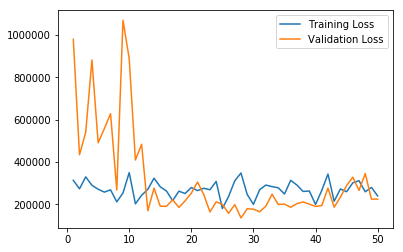

In [16]:
plt.plot(range(1, num_epochs+1), train_loss_beauty_2, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_loss_beauty_2, label='Validation Loss')
plt.legend(loc='best')